<a href="https://colab.research.google.com/github/Emio-eng/SeriesTemporais/blob/main/S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
!pip install pmdarima

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
import kaggle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor

In [11]:
kaggle.api.authenticate()

In [13]:
kaggle.api.dataset_download_files('shenba/time-series-datasets', path='./data', unzip=True)

In [ ]:
df = pd.read_csv('./data/Electric_Production.csv', index_col='DATE', parse_dates=True)
df.head()

In [ ]:
df.shape

In [ ]:
df.describe()

In [ ]:
df.columns = ['consumo']
df.head()

In [22]:
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

In [ ]:
df['consumo'].plot(figsize=(10,6))

# Prevendo com ARIMA

<Figure size 800x600 with 0 Axes>

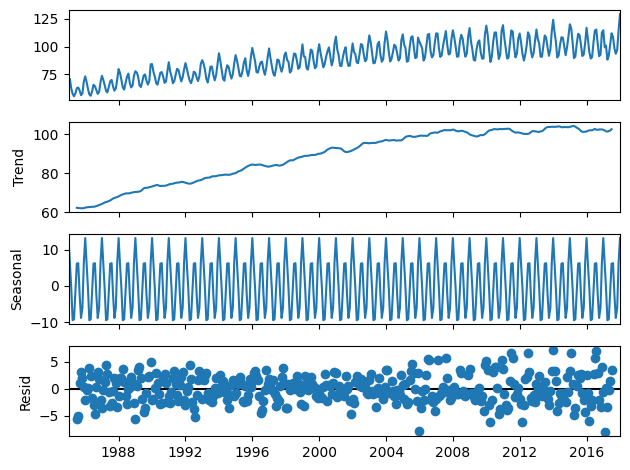

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8,6))
fig = resultado.plot()

Teste de estacionariedade

In [25]:
# Teste de estacionariedade.
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['consumo'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

# Ou seja, a série não é realmente estacionária (p-valor >0.05, não podemos rejeitar a hipótese nula)

Teste ADF:-2.256990350047235
p-valor:0.1862146911658712


In [26]:
# Agora estamos transformando ela em uma série estacionária
# utilizando o diff

from string import printable
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['consumo'].diff().dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-7.104890882267311
p-valor:4.0777865655394095e-10


In [ ]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True,
                           m=6,
                           D=1,
                           start_P=1,
                           start_Q=1,
                           max_P=2,
                           max_Q=2,
                           information_criterion='aic',
                           trace=True,
                           error_action='ignore',
                           stepwise=True)

In [28]:
# ARIMA(2,1,2)(1,1,2)[6]
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(df,order=(2,1,2), seasonal_order=(1,1,2,6))
resultado_sarimax = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
resultado_sarimax.summary()

In [35]:
predicoes = resultado_sarimax.get_prediction(start=-12)
predicoes_media = predicoes.predicted_mean

In [ ]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:, 0]
limites_acima = intervalo_confianca.iloc[:, 1]

limites_abaixo[0], limites_acima[0]

In [ ]:
predicoes_media[0]

In [39]:
datas_previsao = np.asarray(predicoes_media.index)
datas = np.asarray(df.index)

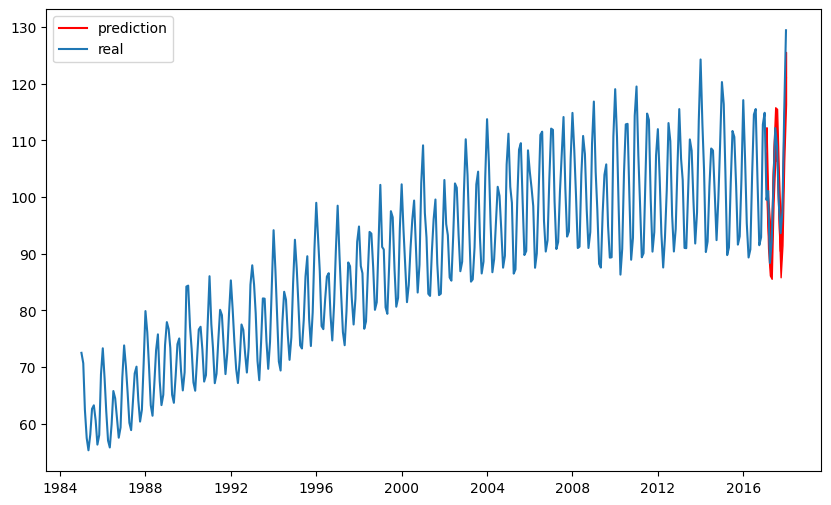

In [40]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicoes_media.values, color='red', label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-12:].values, predicoes_media.values))
print(rmse_sarima)

4.193262204425351


# FORECAST COM ARIMA

In [42]:
# forecast para 12 values

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [ ]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:, 0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:, 1]

intervalo_abaixo_f[0], intervalo_acima_f[0]

In [45]:
forecast_medio[0]

114.55622991777555

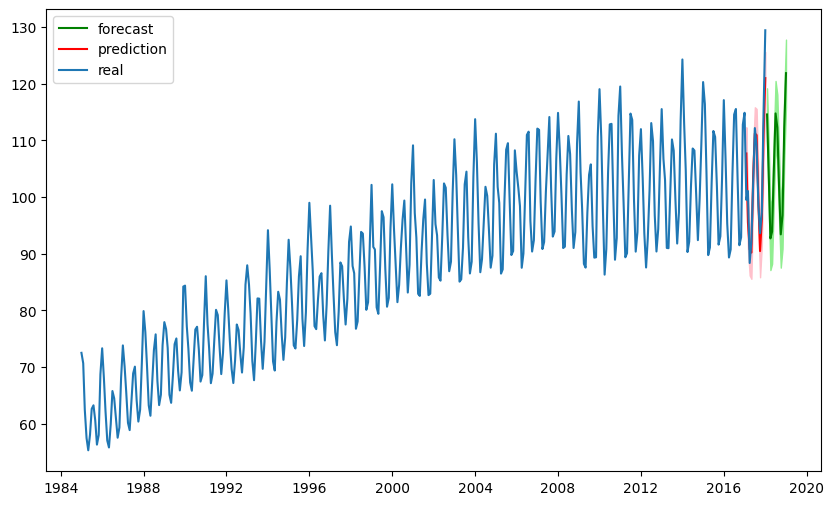

In [46]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates = np.asarray(predicoes_media.index)
dates = np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast, forecast_medio.values, color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao, predicoes_media.values, color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates, df.values, label='real')
plt.legend(loc='upper left')
plt.show()

# Prevendo com XGBoost

In [47]:
df

,consumo
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [48]:
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']

treino.shape, validacao.shape

((384, 1), (13, 1))

In [49]:
treino.index.min(), treino.index.max()


(Timestamp('1985-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [50]:
validacao.index.min(), validacao.index.max()


(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

Criando a variável lagada

In [52]:
treino['consumo']


DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2016-08-01    115.5159
2016-09-01    102.7637
2016-10-01     91.4867
2016-11-01     92.8900
2016-12-01    112.7694
Name: consumo, Length: 384, dtype: float64

In [53]:
# definindo a variavel lagada para 1
treino['consumo'].shift(-1)


DATE
1985-01-01     70.6720
1985-02-01     62.4502
1985-03-01     57.4714
1985-04-01     55.3151
1985-05-01     58.0904
                ...   
2016-08-01    102.7637
2016-09-01     91.4867
2016-10-01     92.8900
2016-11-01    112.7694
2016-12-01         NaN
Name: consumo, Length: 384, dtype: float64

In [54]:
treino['target'] = treino['consumo'].shift(-1)
treino.head()

<ipython-input-54-47b9cd1c1233>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino['consumo'].shift(-1)


,consumo,target
DATE,,
1985-01-01,72.5052,70.6720
1985-02-01,70.6720,62.4502
1985-03-01,62.4502,57.4714
1985-04-01,57.4714,55.3151
1985-05-01,55.3151,58.0904


In [61]:
treino.tail()


,consumo,target
DATE,,
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694
2016-12-01,112.7694,NaN


In [62]:
treino = treino.dropna()
treino.tail()

,consumo,target
DATE,,
2016-07-01,114.5397,115.5159
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694


In [63]:
validacao['target'] = validacao['consumo'].shift(-1)
validacao.head()

,consumo,target
DATE,,
2017-01-01,114.8505,99.4901
2017-02-01,99.4901,101.0396
2017-03-01,101.0396,88.3530
2017-04-01,88.3530,92.0805
2017-05-01,92.0805,102.1532


In [64]:
validacao.tail()

,consumo,target
DATE,,
2017-08-01,108.9312,98.6154
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,NaN


In [65]:
validacao = validacao.dropna()
validacao.tail()

,consumo,target
DATE,,
2017-07-01,112.1538,108.9312
2017-08-01,108.9312,98.6154
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212


In [66]:
X_treino = treino.loc[:, ['consumo']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['consumo']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((383, 1), (383, 1), (11, 1), (11, 1))

In [ ]:
modelo_xgb_um_dia = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgb_um_dia.fit(X_treino, y_treino)

In [68]:
ultima_linha = treino.iloc[-1]
ultima_linha['consumo']

92.89

In [69]:
ultimo_valor_treino = np.array([ultima_linha['consumo']])


In [70]:
predicao = modelo_xgb_um_dia.predict(ultimo_valor_treino)
predicao

array([112.765564], dtype=float32)

In [71]:
X_validacao[0]


array([114.8505])

In [72]:
mean_squared_error(X_validacao[0], predicao)


4.34695827069305